<h2 align=center>Image and Video Processing Lab <br/>
Lab 9 : Blind Image Restortaion</h2>

<h4 align=left>
Roahith R <br/>
22011103048
</h4>

In [45]:
# Import dependencies 
import numpy as np
import matplotlib.pyplot as plt
import cv2

Step 1: Load and prepare image
Loading image, converting to grayscale, and resizing to 256x256


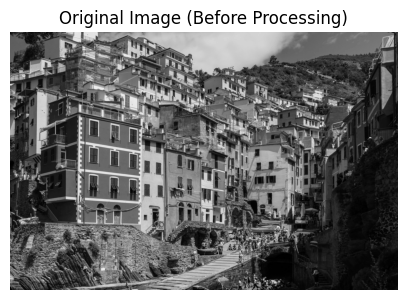

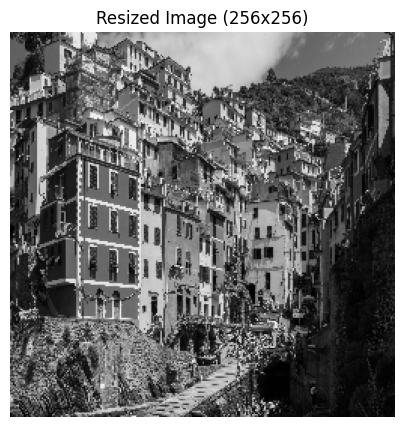

In [46]:
def load_and_prepare_image(image_path):
    """
    Load, convert to grayscale, and resize image to 256x256
    """
    # Load image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Display original image
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    plt.title('Original Image (Before Processing)')
    plt.axis('off')
    plt.show()
    
    # Resize to 256x256 using cv2
    img = cv2.resize(img, (256, 256))
    
    # Normalize to [0, 1]
    img = img / 255.0
    
    # Display processed image
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    plt.title('Resized Image (256x256)')
    plt.axis('off')
    plt.show()
    
    return img

print("Step 1: Load and prepare image")
print("==============================")
print("Loading image, converting to grayscale, and resizing to 256x256")
original_img = load_and_prepare_image("image.jpg")


Step 2: Create Gaussian kernel


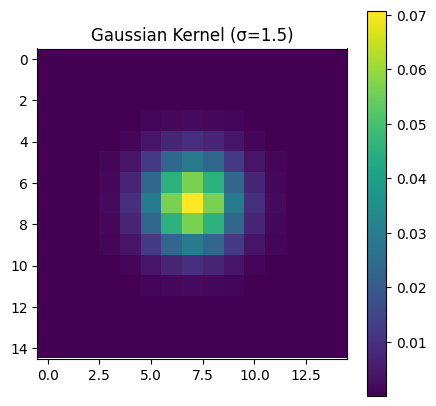

In [47]:
def create_gaussian_kernel(kernel_size=15, sigma=3):
    """
    Create a Gaussian blur kernel
    
    Theory: Gaussian kernel is defined by the formula:
    G(x,y) = (1/(2πσ²)) * exp(-(x²+y²)/(2σ²))
    """
    # Create a meshgrid for x and y coordinates
    ax = np.linspace(-(kernel_size-1)/2, (kernel_size-1)/2, kernel_size)
    xx, yy = np.meshgrid(ax, ax)
    
    # Compute the Gaussian kernel
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    
    # Normalize the kernel to sum to 1
    kernel = kernel / np.sum(kernel)
    
    # Display kernel
    plt.figure(figsize=(5, 5))
    plt.imshow(kernel, cmap='viridis')
    plt.title(f'Gaussian Kernel (σ={sigma})')
    plt.colorbar()
    plt.show()
    
    return kernel


print("\nStep 2: Create Gaussian kernel")
print("=============================")
kernel = create_gaussian_kernel(kernel_size=15, sigma=1.5)


Step 3: Degrade the image
Applying the degradation model: g(x,y) = f(x,y) * h(x,y) + n(x,y)


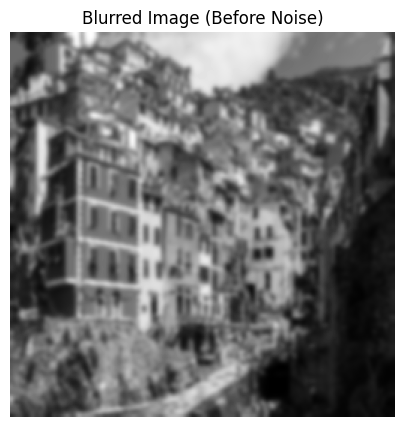

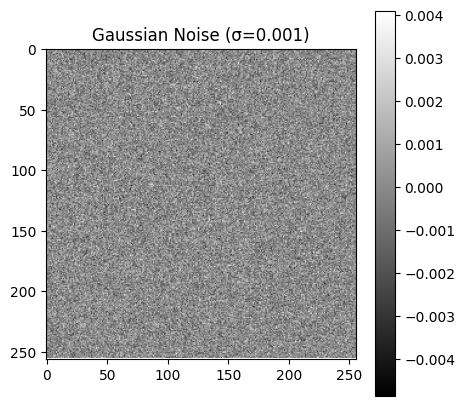

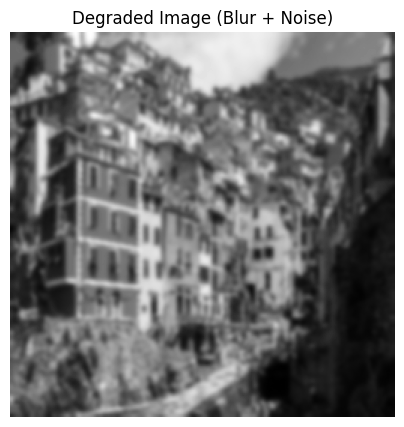

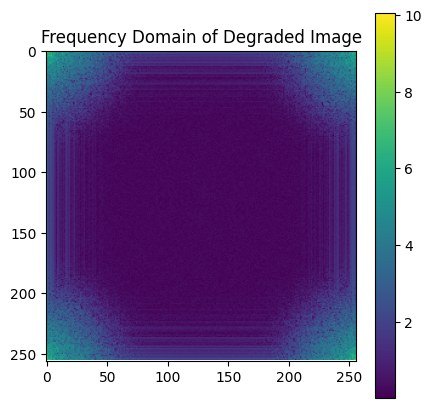

In [48]:
def degrade_image(img, kernel, noise_level=0.01):
    """
    Degrade the image using the formula g(x,y) = f(x,y) * h(x,y) + n(x,y)
    
    Theory: Image degradation model:
    g(x,y) = f(x,y) * h(x,y) + n(x,y) where:
    - g(x,y) is the degraded image
    - f(x,y) is the original image
    - h(x,y) is the degradation function (PSF)
    - n(x,y) is additive noise
    - * denotes convolution
    """
    # Apply manual convolution
    blurred = cv2.filter2D(img,-1, kernel)
    
    # Display blurred image
    plt.figure(figsize=(5, 5))
    plt.imshow(blurred, cmap='gray')
    plt.title('Blurred Image (Before Noise)')
    plt.axis('off')
    plt.show()
    
    # Generate Gaussian noise
    noise = np.random.normal(0, noise_level, img.shape)
    
    # Display noise
    plt.figure(figsize=(5, 5))
    plt.imshow(noise, cmap='gray')
    plt.title(f'Gaussian Noise (σ={noise_level})')
    plt.colorbar()
    plt.show()
    
    # Add noise to create degraded image
    degraded = blurred + noise
    
    # Clip to valid range [0, 1]
    degraded = np.clip(degraded, 0, 1)
    
    # Display degraded image
    plt.figure(figsize=(5, 5))
    plt.imshow(degraded, cmap='gray')
    plt.title('Degraded Image (Blur + Noise)')
    plt.axis('off')
    plt.show()
    
    # Show frequency domain representation
    degraded_fft = np.fft.fft2(degraded)
    degraded_fft_magnitude = np.log(np.abs(degraded_fft) + 1)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(degraded_fft_magnitude, cmap='viridis')
    plt.title('Frequency Domain of Degraded Image')
    plt.colorbar()
    plt.show()
    
    return degraded

print("\nStep 3: Degrade the image")
print("========================")
print("Applying the degradation model: g(x,y) = f(x,y) * h(x,y) + n(x,y)")
degraded_img = degrade_image(original_img, kernel, noise_level=10E-4)


Step 4: Apply Inverse Filter


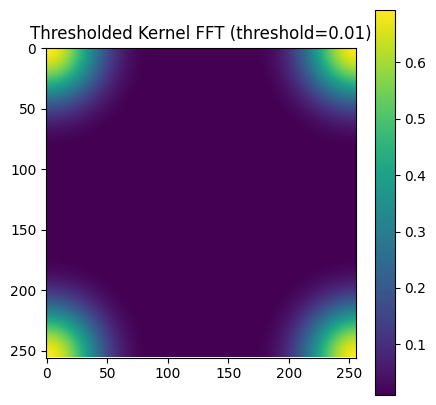

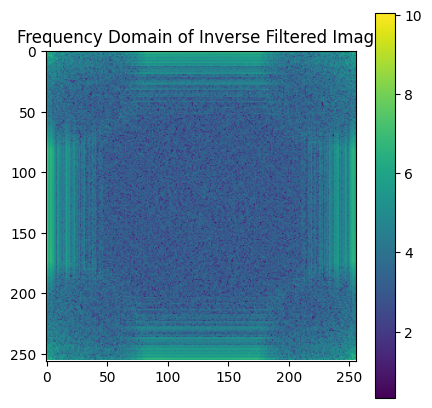

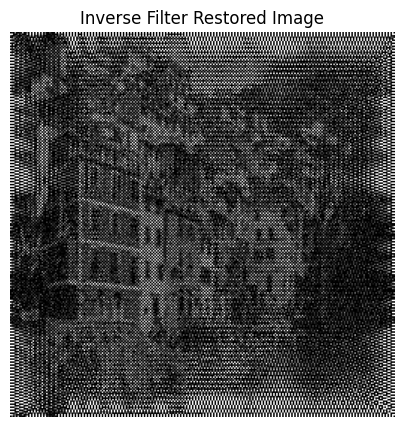

In [49]:
def manual_inverse_filter(degraded_img, kernel, threshold=0.01):
    """
    Restore image using manually implemented inverse filter
    
    Theory: In frequency domain, the degradation model is:
    G(u,v) = F(u,v) * H(u,v) + N(u,v)
    
    The inverse filter attempts to recover F(u,v) by:
    F̂(u,v) = G(u,v) / H(u,v)
    """
    # Pad kernel to match image size
    img_height, img_width = degraded_img.shape
    k_height, k_width = kernel.shape
    
    padded_kernel = np.zeros((img_height, img_width))
    start_h = (img_height - k_height) // 2
    start_w = (img_width - k_width) // 2
    padded_kernel[start_h:start_h+k_height, start_w:start_w+k_width] = kernel
    
    padded_kernel = np.fft.ifftshift(padded_kernel)
    
    # Compute FFT of degraded image and kernel
    degraded_fft = np.fft.fft2(degraded_img)
    kernel_fft = np.fft.fft2(padded_kernel)
    
    # Apply threshold to avoid division by zero or very small values
    kernel_fft_thresholded = kernel_fft.copy()
    kernel_fft_thresholded[np.abs(kernel_fft) < threshold] = threshold
    
    # Display thresholded kernel frequency response
    kernel_fft_magnitude = np.abs(kernel_fft_thresholded)
    plt.figure(figsize=(5, 5))
    plt.imshow(np.log(kernel_fft_magnitude + 1), cmap='viridis')
    plt.title(f'Thresholded Kernel FFT (threshold={threshold})')
    plt.colorbar()
    plt.show()
    
    # Perform inverse filtering in frequency domain
    restored_fft = degraded_fft / kernel_fft_thresholded
    
    # Display restored frequency response
    restored_fft_magnitude = np.abs(restored_fft)
    plt.figure(figsize=(5, 5))
    plt.imshow(np.log(restored_fft_magnitude + 1), cmap='viridis')
    plt.title('Frequency Domain of Inverse Filtered Image')
    plt.colorbar()
    plt.show()
    
    
    # Shift back before inverse FFT
    restored_fft = np.fft.ifftshift(restored_fft)
    
    # Convert back to spatial domain
    restored = np.fft.ifft2(restored_fft).real
    
    # Clip and normalize
    restored = np.clip(restored, 0, 1)
    
    # Display restored image
    plt.figure(figsize=(5, 5))
    plt.imshow(restored, cmap='gray')
    plt.title('Inverse Filter Restored Image')
    plt.axis('off')
    plt.show()
    
    return restored

print("\nStep 4: Apply Inverse Filter")
print("===========================")
inverse_restored = manual_inverse_filter(degraded_img, kernel, threshold=0.01)




Step 5: Apply Wiener Filter
Theory: The Wiener filter uses a statistical approach to minimize the mean square error:
F̂(u,v) = [H*(u,v)/(|H(u,v)|^2 + K)] * G(u,v)




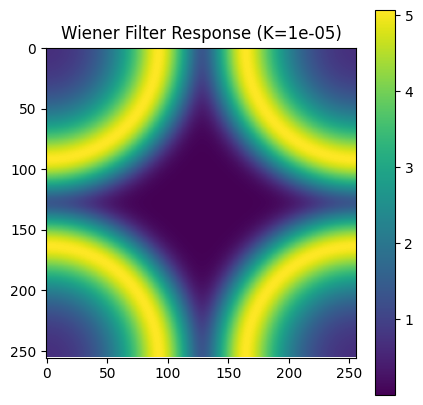

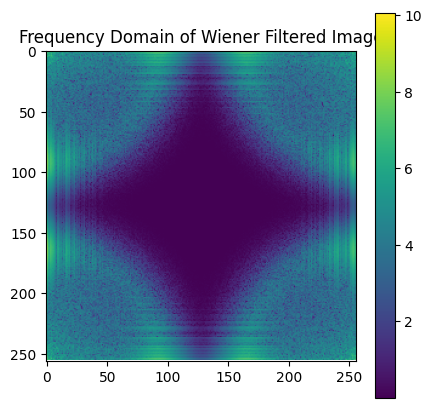

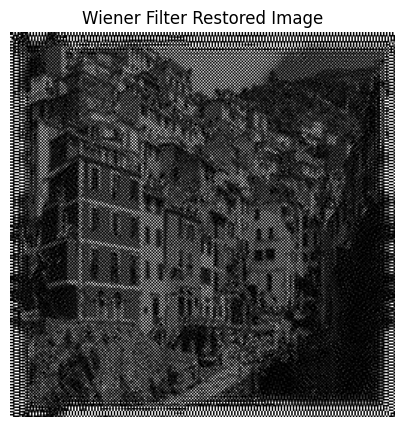

In [50]:
def manual_wiener_filter(degraded_img, kernel, K=0.01):
    """
    Restore image using manually implemented Wiener filter
    
    Theory: The Wiener filter is defined in frequency domain as:
    F̂(u,v) = [H*(u,v)/(|H(u,v)|^2 + K)] * G(u,v)
    
    Where:
    - H*(u,v) is the complex conjugate of H(u,v)
    - |H(u,v)|^2 is the power spectrum of the degradation
    - K is a constant related to the noise-to-signal ratio
    """
    # Pad kernel to match image size
    img_height, img_width = degraded_img.shape
    k_height, k_width = kernel.shape
    
    padded_kernel = np.zeros((img_height, img_width))
    start_h = (img_height - k_height) // 2
    start_w = (img_width - k_width) // 2
    padded_kernel[start_h:start_h+k_height, start_w:start_w+k_width] = kernel
    
    padded_kernel = np.fft.ifftshift(padded_kernel)
    
    # Compute FFT of degraded image and kernel
    degraded_fft = np.fft.fft2(degraded_img)
    kernel_fft = np.fft.fft2(padded_kernel)
    
    # Compute Wiener filter
    kernel_fft_conj = np.conjugate(kernel_fft)
    denominator = np.abs(kernel_fft)**2 + K
    
    # Create the Wiener filter
    wiener_filter = kernel_fft_conj / denominator
    
    # Display Wiener filter frequency response
    wiener_magnitude = np.abs(wiener_filter)
    plt.figure(figsize=(5, 5))
    plt.imshow(np.log(wiener_magnitude + 1), cmap='viridis')
    plt.title(f'Wiener Filter Response (K={K})')
    plt.colorbar()
    plt.show()
    
    # Apply Wiener filter
    restored_fft = degraded_fft * wiener_filter
    
    # Display restored frequency response
    restored_fft_magnitude = np.abs(restored_fft)
    plt.figure(figsize=(5, 5))
    plt.imshow(np.log(restored_fft_magnitude + 1), cmap='viridis')
    plt.title('Frequency Domain of Wiener Filtered Image')
    plt.colorbar()
    plt.show()
    
    # Shift back before inverse FFT
    restored_fft = np.fft.ifftshift(restored_fft)
    
    # Convert back to spatial domain
    restored = np.fft.ifft2(restored_fft).real
    
    # Clip and normalize
    restored = np.clip(restored, 0, 1)
    
    # Display restored image
    plt.figure(figsize=(5, 5))
    plt.imshow(restored, cmap='gray')
    plt.title('Wiener Filter Restored Image')
    plt.axis('off')
    plt.show()
    
    return restored


print("\nStep 5: Apply Wiener Filter")
print("===========================")
print("Theory: The Wiener filter uses a statistical approach to minimize the mean square error:")
print("F̂(u,v) = [H*(u,v)/(|H(u,v)|^2 + K)] * G(u,v)")
print("\n")
wiener_restored = manual_wiener_filter(degraded_img, kernel, K=10E-6)


Step 6: Calculate PSNR
Theory: Peak Signal-to-Noise Ratio (PSNR):
PSNR = 10 * log10(MAX²/MSE), where MAX is the maximum pixel value (1.0 here).


PSNR for Degraded Image:


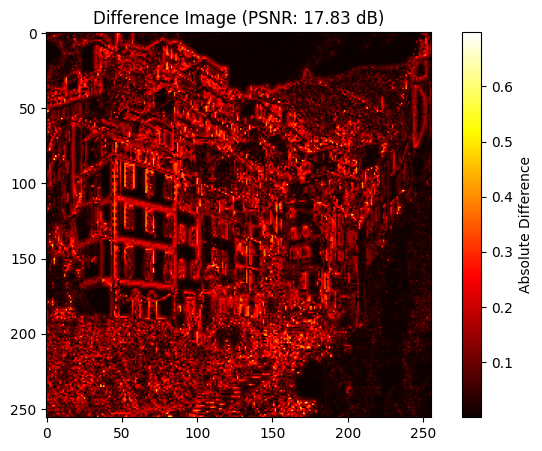


PSNR for Inverse Filter Restored Image:


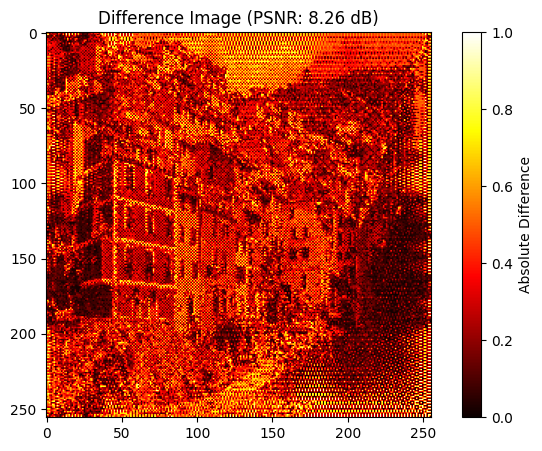


PSNR for Wiener Filter Restored Image:


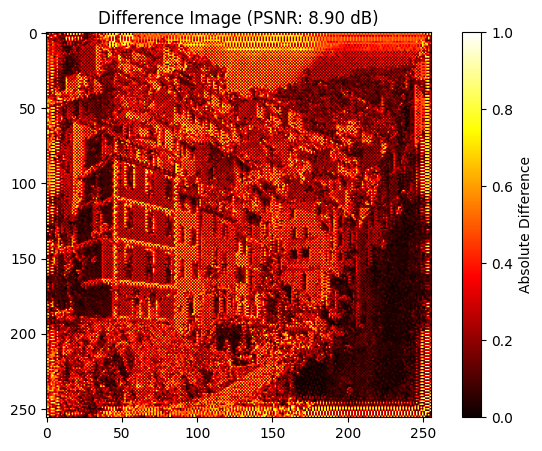

In [51]:
def calculate_psnr_manually(original, restored):
    """
    Calculate PSNR manually
    
    Theory: Peak Signal-to-Noise Ratio (PSNR) is defined as:
    PSNR = 10 * log10(MAX²/MSE)
    
    Where:
    - MAX is the maximum pixel value (1.0 for normalized images)
    - MSE is the Mean Squared Error: (1/N) * Σ[I₁(i,j) - I₂(i,j)]²
    """
    # Calculate MSE manually
    mse = 0
    pixel_count = original.shape[0] * original.shape[1]
    
    for i in range(original.shape[0]):
        for j in range(original.shape[1]):
            mse += (original[i, j] - restored[i, j]) ** 2
    
    mse = mse / pixel_count
    
    # Calculate PSNR
    max_pixel = 1.0  # Assuming image is normalized to [0,1]
    psnr_value = 10 * np.log10((max_pixel ** 2) / mse) if mse > 0 else 100
    
    # Calculate and display difference image
    diff = np.abs(original - restored)
    plt.figure(figsize=(8, 5))
    plt.imshow(diff, cmap='hot')
    plt.title(f'Difference Image (PSNR: {psnr_value:.2f} dB)')
    plt.colorbar(label='Absolute Difference')
    plt.show()
    
    return psnr_value

print("\nStep 6: Calculate PSNR")
print("====================")
print("Theory: Peak Signal-to-Noise Ratio (PSNR):")
print("PSNR = 10 * log10(MAX²/MSE), where MAX is the maximum pixel value (1.0 here).")
print("\n")

print("PSNR for Degraded Image:")
degraded_psnr = calculate_psnr_manually(original_img, degraded_img)

print("\nPSNR for Inverse Filter Restored Image:")
inverse_psnr = calculate_psnr_manually(original_img, inverse_restored)

print("\nPSNR for Wiener Filter Restored Image:")
wiener_psnr = calculate_psnr_manually(original_img, wiener_restored)
    


Step 7: Calculate MLE statistics
Theory: Maximum Likelihood Estimation (MLE) of mean and standard deviation:
Mean: μ = (1/N) * Σx
Standard Deviation: σ = sqrt((1/N) * Σ(x - μ)²)


Original Image Statistics:


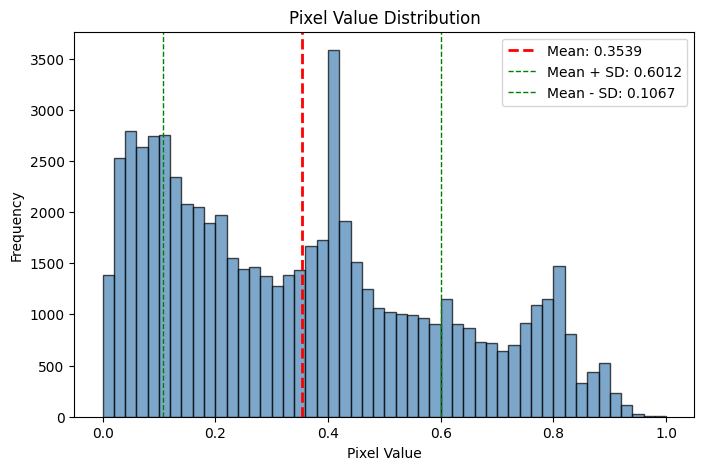


Degraded Image Statistics:


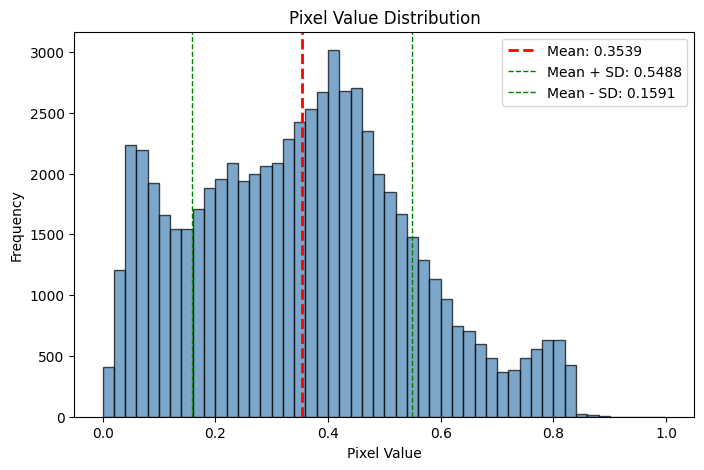


Inverse Filter Restored Image Statistics:


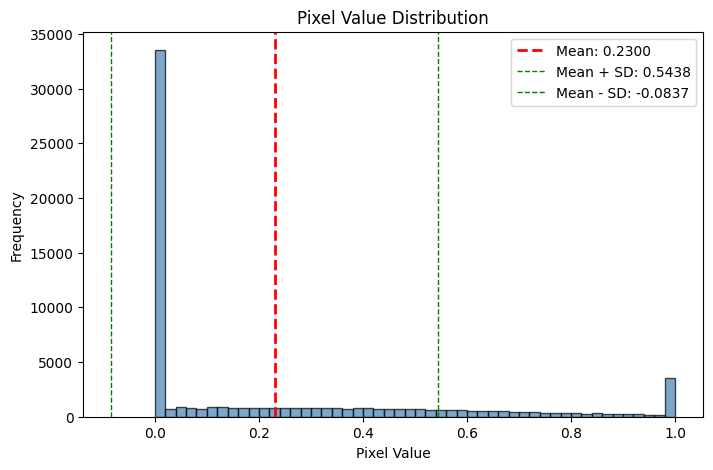


Wiener Filter Restored Image Statistics:


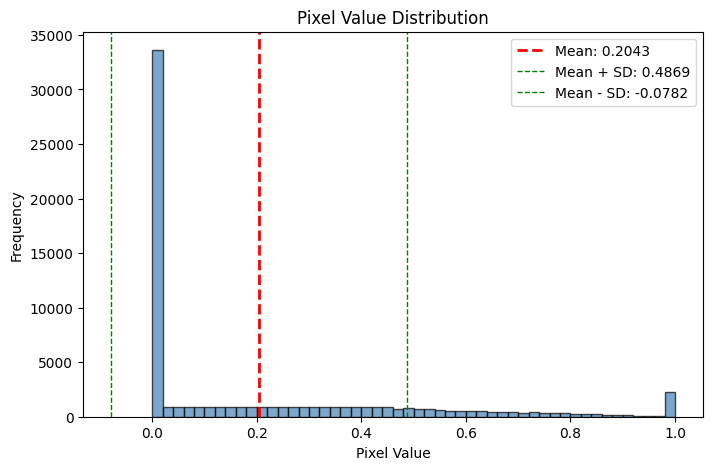

In [52]:
def calculate_statistics(image):
    """
    Calculate MLE statistics (Mean and Standard Deviation) manually
    
    Theory: For Gaussian distributed data, the Maximum Likelihood Estimation (MLE) 
    of mean and standard deviation are:
    - Mean: μ = (1/N) * Σx
    - Standard Deviation: σ = sqrt((1/N) * Σ(x - μ)²)
    """
    # Manual calculation of mean
    total = 0
    pixel_count = image.shape[0] * image.shape[1]
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            total += image[i, j]
    
    mean = total / pixel_count
    
    # Manual calculation of standard deviation
    sum_squared_diff = 0
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            sum_squared_diff += (image[i, j] - mean) ** 2
    
    std_dev = np.sqrt(sum_squared_diff / pixel_count)
    
    # Display histogram manually
    plt.figure(figsize=(8, 5))
    
    # Flatten image and create histogram bins
    flattened = image.flatten()
    hist, bin_edges = np.histogram(flattened, bins=50, range=(0, 1))
    
    # Plot histogram manually
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.bar(bin_centers, hist, width=(bin_edges[1] - bin_edges[0]), color='steelblue', edgecolor='black', alpha=0.7)
    
    # Add lines for mean and std dev
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.4f}')
    plt.axvline(mean + std_dev, color='green', linestyle='dashed', linewidth=1, label=f'Mean + SD: {mean+std_dev:.4f}')
    plt.axvline(mean - std_dev, color='green', linestyle='dashed', linewidth=1, label=f'Mean - SD: {mean-std_dev:.4f}')
    
    plt.title('Pixel Value Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
    return mean, std_dev

print("\nStep 7: Calculate MLE statistics")
print("===============================")
print("Theory: Maximum Likelihood Estimation (MLE) of mean and standard deviation:")
print("Mean: μ = (1/N) * Σx")
print("Standard Deviation: σ = sqrt((1/N) * Σ(x - μ)²)")
print("\n")
print("Original Image Statistics:")
original_stats = calculate_statistics(original_img)

print("\nDegraded Image Statistics:")
degraded_stats = calculate_statistics(degraded_img)

print("\nInverse Filter Restored Image Statistics:")
inverse_stats = calculate_statistics(inverse_restored)

print("\nWiener Filter Restored Image Statistics:")
wiener_stats = calculate_statistics(wiener_restored)


Step 8: Final Comparison


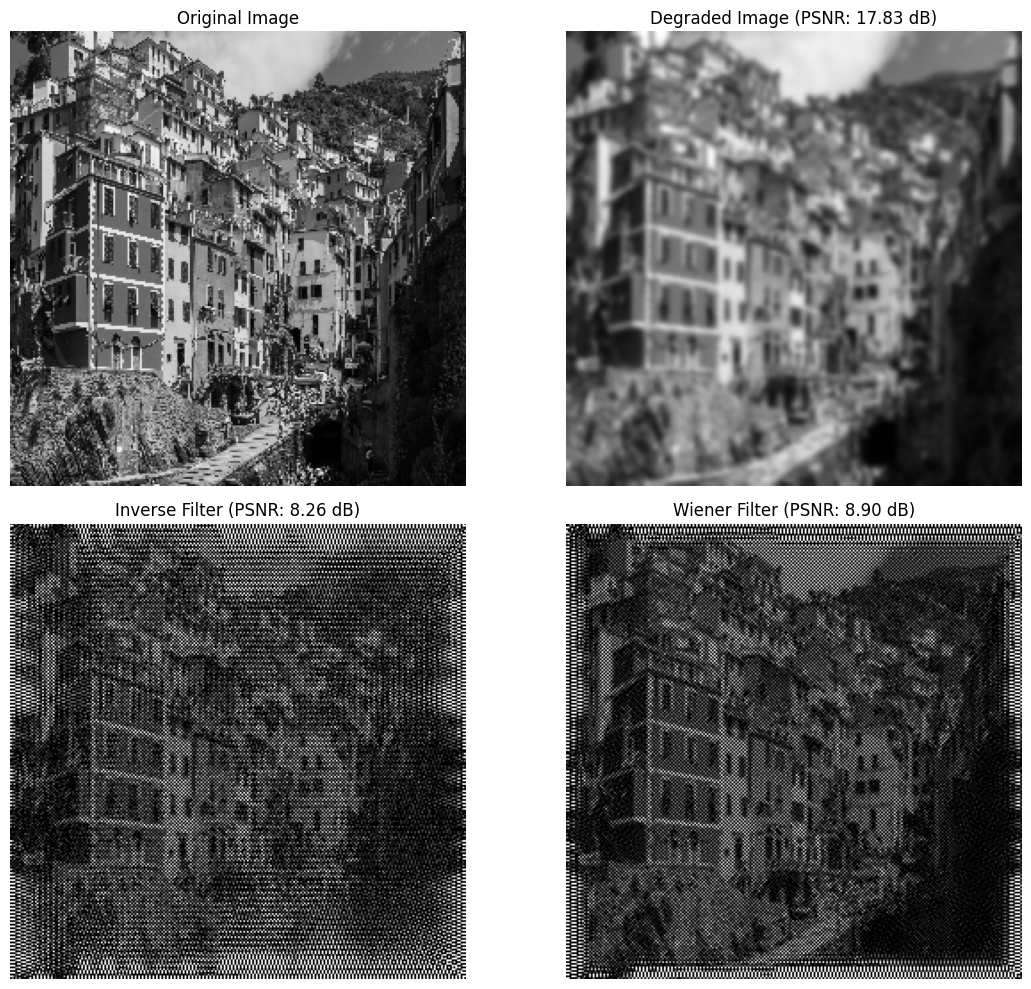


Final Statistics Summary:
Image Type                Mean       Std Dev    PSNR (dB) 
------------------------------------------------------------
Original                  0.3539     0.2472     N/A       
Degraded                  0.3539     0.1949     17.83     
Inverse Filter Restored   0.2300     0.3138     8.26      
Wiener Filter Restored    0.2043     0.2825     8.90      


In [53]:
print("\nStep 8: Final Comparison")
print("======================")

# Final comparison
plt.figure(figsize=(12, 10))
    
plt.subplot(2, 2, 1)
plt.imshow(original_img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(degraded_img, cmap='gray')
plt.title(f'Degraded Image (PSNR: {degraded_psnr:.2f} dB)')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(inverse_restored, cmap='gray')
plt.title(f'Inverse Filter (PSNR: {inverse_psnr:.2f} dB)')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(wiener_restored, cmap='gray')
plt.title(f'Wiener Filter (PSNR: {wiener_psnr:.2f} dB)')
plt.axis('off')

plt.tight_layout()
plt.show()
    
# Final statistics table
print("\nFinal Statistics Summary:")
print("=======================")
print(f"{'Image Type':<25} {'Mean':<10} {'Std Dev':<10} {'PSNR (dB)':<10}")
print("-" * 60)
print(f"{'Original':<25} {original_stats[0]:<10.4f} {original_stats[1]:<10.4f} {'N/A':<10}")
print(f"{'Degraded':<25} {degraded_stats[0]:<10.4f} {degraded_stats[1]:<10.4f} {degraded_psnr:<10.2f}")
print(f"{'Inverse Filter Restored':<25} {inverse_stats[0]:<10.4f} {inverse_stats[1]:<10.4f} {inverse_psnr:<10.2f}")
print(f"{'Wiener Filter Restored':<25} {wiener_stats[0]:<10.4f} {wiener_stats[1]:<10.4f} {wiener_psnr:<10.2f}")
